<a href="https://colab.research.google.com/github/jw3215/hhplus-ai-1/blob/main/%EC%8B%A0%EC%A2%85%EC%9A%B0/1_3_MNIST(1%EC%A3%BC%EC%B0%A8_%EA%B3%BC%EC%A0%9C).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST 실습

이번에는 28x28 흑백 손글씨 이미지를 보고 0~9 사이의 숫자 중 어떤 숫자를 쓴 것인지 예측하는 문제를 실습합니다.
이번 실습에서는 GPU를 활용할 것이기 때문에, 이전 챕터에서 Colab에서 GPU를 설정하는 방법을 따라해주시길 바랍니다.

GPU를 설정했으면 library들을 import합니다.

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
print("!!")

다음은 dataset을 준비합니다. 손글씨 dataset은 MNIST라는 유명한 dataset이 있습니다. 이 dataset은 `torchvision`에서 제공하고 있으며, 다음과 같이 다운로드 받을 수 있습니다.

In [ ]:
transform = transforms.ToTensor()

trainset = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:02<00:00, 4155836.06it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 65004.57it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1264063.09it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 4057620.61it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



MNIST는 손글씨 사진과 어떤 숫자를 의미하는지에 대한 label의 pair들로 구성되어있습니다.
이 때, 우리는 PyTorch model을 사용할 것이기 때문에 손글씨 사진들을 모두 tensor로 변환해야합니다.
이러한 부가적인 변환들은 `torchvision.transforms`에서 제공하고 있으며, `torchvision.datasets.MNIST`에서 `transform` 인자로 받을 수 있습니다.
우리는 단순히 사진을 tensor로 바꾸고 싶기 때문에 `transforms.ToTensor()` transformation을 넘겨줍니다.

다음은 전체 data의 개수와 첫 번째 data를 출력한 결과입니다.

60000
torch.Size([1, 28, 28]) 5


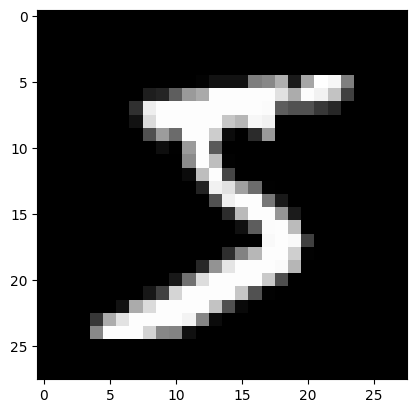

In [ ]:
from matplotlib import pyplot as plt

print(len(trainset))
print(trainset[0][0].shape, trainset[0][1])
plt.imshow(trainset[0][0][0], cmap='gray')

첫 번째 출력결과를 통해 우리는 6만장의 손글씨 data가 있는 것을 알 수 있습니다.
그리고 두 번째 출력결과를 통해 첫 번째 data의 shape은 (1, 28, 28)이고 5라는 숫자를 쓴 사진이라는 것을 알 수 있습니다.
마지막으로 `plt.imshow`를 통해 visualize 했을 때 5라는 숫자가 나오는 것을 알 수 있습니다.

다음은 SGD를 위해 dataset을 여러 개의 batch로 나누는 과정을 PyTorch로 구현한 모습입니다.

In [ ]:
batch_size = 256

trainloader = torch.utils.data.DataLoader(
    trainset,
    batch_size=batch_size,
    shuffle=True
)

PyTorch에서는 `DataLoader`가 dataset을 인자로 받아 batch로 나눠줍니다.
부가적으로 `batch_size`라는 인자를 통해 batch size를 받고 있으며, `shuffle`이라는 인자를 통해 data들을 섞을지 결정해줍니다.
우리는 SGD가 완전 랜덤으로 batch를 구성해야 잘 동작하는 것을 알고 있기 때문에 `shuffle`에 `True`를 넘겨주고 있습니다.

다음은 첫 번째 batch를 출력한 모습입니다.

In [ ]:
dataiter = iter(trainloader)
images, labels = next(dataiter)
print(images.shape, labels.shape)

torch.Size([256, 1, 28, 28]) torch.Size([256])


`images`는 첫 번째 batch의 image들이고 `labels`는 첫 번째 batch의 label들입니다.
위에서 batch size를 64로 설정했기 때문에 총 64개의 image와 label들이 있어야 합니다.
실제 shape 출력 결과를 보면 그렇다는 것을 알 수 있습니다.

다음은 (n, 1, 28, 28) shape의 image를 입력받아 0~9 사이의 정수 하나를 출력하는 3-layer MLP를 구현합니다.

In [ ]:
from torch import nn


class Model(nn.Module):
  def __init__(self, input_dim, n_dim):
    super().__init__()

    self.layer1 = nn.Linear(input_dim, n_dim)
    self.layer2 = nn.Linear(n_dim, n_dim)
    self.layer3 = nn.Linear(n_dim, 10)

    self.act = nn.ReLU()

  def forward(self, x):
    x = torch.flatten(x, start_dim=1)
    x = self.act(self.layer1(x))
    x = self.act(self.layer2(x))
    x = self.act(self.layer3(x))

    return x


model = Model(28 * 28 * 1, 1024)

이전의 2-layer MLP와 유사한 형태임을 알 수 있습니다.
여기서 특이사항은 `forward`의 첫 번째 줄에 `torch.flatten`을 사용한다는 것입니다.
`Linear`는 이전에도 봤다시피 (n, d) 형태의 shape을 입력받습니다.
이미지는 (n, 1, 28, 28)이기 때문에 (n, 1 * 28 * 28)로 shape을 변환해야 선형 함수에 입력으로 주어줄 수 있게 됩니다.
이 역할을 수행하는 것이 바로 `torch.flatten`입니다.
우리는 첫 번째 shape인 n을 보존할 것이기 때문에 flatten할 차원은 `start_dim=1`로 넘겨주게 됩니다.

다음은 gradient descent를 수행해줄 optimizer를 구현하는 모습입니다.

In [ ]:
from torch.optim import SGD

lr = 0.001
model = model.to('cuda')

optimizer = SGD(model.parameters(), lr=lr)

이전 코드와 거의 똑같습니다. 다른 점은 `model.to('cuda')` 코드를 통해 우리가 구현한 model을 GPU로 옮긴 것입니다.
MNIST 부터는 모델과 data가 커지면서 훨씬 많은 행렬 연산이 이루어지기 때문에 GPU를 활용하는 것이 빠릅니다.

다음은 model을 MNIST에 학습하는 코드입니다.

In [ ]:
def accuracy(model, dataloader):
  cnt = 0
  acc = 0

  for data in dataloader:
    # print(data)
    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    preds = model(inputs)
    preds = torch.argmax(preds, dim=-1)

    cnt += labels.shape[0]
    acc += (labels == preds).sum().item()

  print(acc, cnt)
  return acc / cnt

In [ ]:
# Test data 준비하기
testset = torchvision.datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

In [ ]:
# test data loader
testloader = torch.utils.data.DataLoader(
    testset,
    batch_size=batch_size,
    shuffle=False
)

In [ ]:
n_epochs = 100

train_accs = []
test_accs = []

for epoch in range(n_epochs):
  total_loss = 0.
  for data in trainloader:
    model.zero_grad()
    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    preds = model(inputs)
    # loss = (preds[:, 0] - labels).pow(2).mean()
    loss = torch.nn.CrossEntropyLoss()(preds, labels)


    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  train_accs.append(accuracy(model, trainloader))
  test_accs.append(accuracy(model, testloader))
  print(f"Epoch {epoch:3d} | Loss: {total_loss}")



36008 60000
6136 10000
Epoch   0 | Loss: 521.2478039264679
36361 60000
6207 10000
Epoch   1 | Loss: 516.6303865909576
36523 60000
6247 10000
Epoch   2 | Loss: 511.45149183273315
36636 60000
6247 10000
Epoch   3 | Loss: 505.627090215683
36798 60000
6266 10000
Epoch   4 | Loss: 499.0361452102661
36991 60000
6297 10000
Epoch   5 | Loss: 491.6571192741394
37167 60000
6318 10000
Epoch   6 | Loss: 483.34405994415283
37477 60000
6370 10000
Epoch   7 | Loss: 474.1156620979309
37803 60000
6430 10000
Epoch   8 | Loss: 463.8914430141449
38154 60000
6488 10000
Epoch   9 | Loss: 452.8372724056244
38506 60000
6556 10000
Epoch  10 | Loss: 440.7695873975754
38873 60000
6602 10000
Epoch  11 | Loss: 427.98009061813354
39210 60000
6654 10000
Epoch  12 | Loss: 414.4609191417694
39486 60000
6699 10000
Epoch  13 | Loss: 400.4412188529968
39890 60000
6760 10000
Epoch  14 | Loss: 386.2147023677826
40228 60000
6806 10000
Epoch  15 | Loss: 371.9124536514282
40679 60000
6895 10000
Epoch  16 | Loss: 357.774973630

In [ ]:
# print(accuracy(model, trainloader))
# print(accuracy(model, testloader))
print(train_accs)
print(test_accs)

[0.6001333333333333, 0.6060166666666666, 0.6087166666666667, 0.6106, 0.6133, 0.6165166666666667, 0.61945, 0.6246166666666667, 0.63005, 0.6359, 0.6417666666666667, 0.6478833333333334, 0.6535, 0.6581, 0.6648333333333334, 0.6704666666666667, 0.6779833333333334, 0.6858333333333333, 0.6942833333333334, 0.7024, 0.70845, 0.71515, 0.7206666666666667, 0.7255833333333334, 0.729, 0.7338833333333333, 0.73735, 0.7411, 0.7445, 0.7476666666666667, 0.7508, 0.7530666666666667, 0.7562666666666666, 0.7587166666666667, 0.7603, 0.763, 0.7647333333333334, 0.76725, 0.7689, 0.771, 0.7723833333333333, 0.7737833333333334, 0.7763333333333333, 0.7778, 0.7794, 0.7809333333333334, 0.7822833333333333, 0.7839, 0.78505, 0.7861666666666667, 0.7869, 0.78835, 0.7890666666666667, 0.7901166666666667, 0.7910666666666667, 0.7919166666666667, 0.7929333333333334, 0.7934666666666667, 0.7941, 0.7952333333333333, 0.7963833333333333, 0.7967333333333333, 0.7973833333333333, 0.79795, 0.7982666666666667, 0.799, 0.7996, 0.800483333333

출력 결과를 보면 잘 수렴하는 것을 볼 수 있습니다.
이전 구현과 다른 점은 다음 두 가지입니다.
- `for data in trainloader`를 통해 batch들을 iterate하면서 model을 학습합니다.
- `inputs, labels = inputs.to('cuda'), labels.to('cuda')`를 통해 model의 입력으로 들어가는 tensor들을 GPU로 보냅니다.

마지막으로 첫 번째 data에 대한 예측 결과를 살펴봅시다.

In [ ]:
import torch.nn.functional as F

idx = 0
for idx in range(20):
  x = trainset[idx][0][None]  # (1, 1, 28, 28)
  x = x.to('cuda')
  _, predicted_class= torch.max(F.softmax(model(x)), dim=1)
  print(predicted_class)
  # print(torch.max(F.softmax(model(x))))
  # for x,j in enumerate(iter(F.softmax(model(x)))):
  #   print(x,j)
  print(trainset[idx][1])




tensor([3], device='cuda:0')
5
tensor([0], device='cuda:0')
0
tensor([4], device='cuda:0')
4
tensor([1], device='cuda:0')
1
tensor([9], device='cuda:0')
9
tensor([2], device='cuda:0')
2
tensor([1], device='cuda:0')
1
tensor([3], device='cuda:0')
3
tensor([1], device='cuda:0')
1
tensor([4], device='cuda:0')
4
tensor([3], device='cuda:0')
3
tensor([8], device='cuda:0')
5
tensor([3], device='cuda:0')
3
tensor([0], device='cuda:0')
6
tensor([1], device='cuda:0')
1
tensor([7], device='cuda:0')
7
tensor([2], device='cuda:0')
2
tensor([8], device='cuda:0')
8
tensor([5], device='cuda:0')
6
tensor([9], device='cuda:0')
9


<ipython-input-39-be5fa8b69981>:7: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted_class= torch.max(F.softmax(model(x)), dim=1)


여기서 idx를 조정하여 다른 data에 대한 출력 결과도 볼 수 있습니다.
예측 결과를 보시면 아직 성능이 그렇게 좋지 않은 것을 알 수 있습니다.

=====================================

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_acc(train_accs, test_accs, label1='train', label2='test'):
  x = np.arange(len(train_accs))

  plt.plot(x, train_accs, label=label1)
  plt.plot(x, test_accs, label=label2)
  plt.legend()
  plt.show()

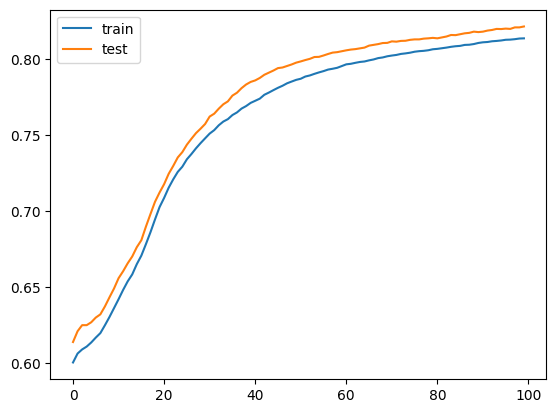

In [ ]:
plot_acc(train_accs, test_accs)